http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

$\theta$: the mean of some normal distribution; we want to estimate theta.

$x$: data from the distribution

$p(x|\theta)$: likelihood

$p(\theta)$: prior

$p(\theta|x)$: posterior


Bayes formula:

$p(\theta|x) = likelihood * prior / p(x) = p(x|\theta) * p(\theta) / p(x)$

$p(x) = \int_\theta P(x, \theta)d\theta$

Assume prior $p(\theta)$ ~ norm(prior_mu_theta=0, prior_sd_theta=1)

Assume likelihood $p(x|\theta)$ ~ $norm(\theta, 1)$



In [24]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [27]:
theta_data = 1
sd_data = 1
x = sd_data*np.random.randn(20) + theta_data

In [28]:
prior_mu_theta = 0
prior_sd_theta = 1
# prior p(theta) ~ norm(prior_mu_theta=0, prior_sd_theta=1)

theta_current = 0.

prior_current = norm(prior_mu_theta, prior_sd_theta).pdf(theta_current)

In [41]:
#  In this simple case, we will assume that this data is normal distributed, 
# i.e. the likelihood of the model is normal.
# likelihood p(x|theta) ~ norm(theta, 1)
likelihood_current = norm(theta_current, 1).pdf(x).prod()

In [43]:
# Then, you propose to move (jump) from that position somewhere else (that's the Markov part). 
proposal_width = 1
theta_proposal = norm(theta_current, proposal_width).rvs()

In [44]:
# prior p(theta) ~ norm(prior_mu_theta=0, prior_sd_theta=1)
prior_proposal = norm(prior_mu_theta, prior_sd_theta).pdf(theta_proposal)
# likelihood p(x|theta) ~ norm(theta, 1)
likelihood_proposal = norm(theta_proposal, 1).pdf(x).prod()

In [45]:
# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal
p_accept = p_proposal / p_current

In [69]:
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = theta_proposal

In [70]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

In [71]:
def sampler(data, samples=4, theta_init=.5, proposal_width=.5, plot=False, prior_mu_theta=0, prior_sd_theta=1.):
    theta_current = theta_init
    posterior = [theta_current]
    for i in range(samples):
        # suggest new position
        theta_proposal = norm(theta_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(theta_current, 1).pdf(data).prod()
        likelihood_proposal = norm(theta_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(prior_mu_theta, prior_sd_theta).pdf(theta_current)
        prior_proposal = norm(prior_mu_theta, prior_sd_theta).pdf(theta_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(theta_current, theta_proposal, prior_mu_theta, prior_sd_theta, data, accept, posterior, i)
        
        if accept:
            # Update position
            theta_current = theta_proposal
        
        posterior.append(theta_current)
        
    return posterior

In [72]:
# Function to display
def plot_proposal(theta_current, theta_proposal, prior_mu_theta, prior_sd_theta, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(prior_mu_theta, prior_sd_theta).pdf(theta_current)
    prior_proposal = norm(prior_mu_theta, prior_sd_theta).pdf(theta_proposal)
    prior = norm(prior_mu_theta, prior_sd_theta).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([theta_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([theta_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(theta_proposal, 0.2), xytext=(theta_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (theta_current, prior_current, theta_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(theta_current, 1).pdf(data).prod()
    likelihood_proposal = norm(theta_proposal, 1).pdf(data).prod()
    y = norm(loc=theta_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(theta_current, color='b', linestyle='--', label='theta_current')
    ax2.axvline(theta_proposal, color=color, linestyle='--', label='theta_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(theta_proposal, 0.2), xytext=(theta_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (theta_current, 1e14*likelihood_current, theta_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, prior_mu_theta, prior_sd_theta)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, theta_current, prior_mu_theta, prior_sd_theta)
    posterior_proposal = calc_posterior_analytical(data, theta_proposal, prior_mu_theta, prior_sd_theta)
    ax3.plot([theta_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([theta_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(theta_proposal, 0.2), xytext=(theta_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (theta_current, posterior_current, theta_proposal, posterior_proposal))
    
    if accepted:
        trace.append(theta_proposal)
    else:
        trace.append(theta_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

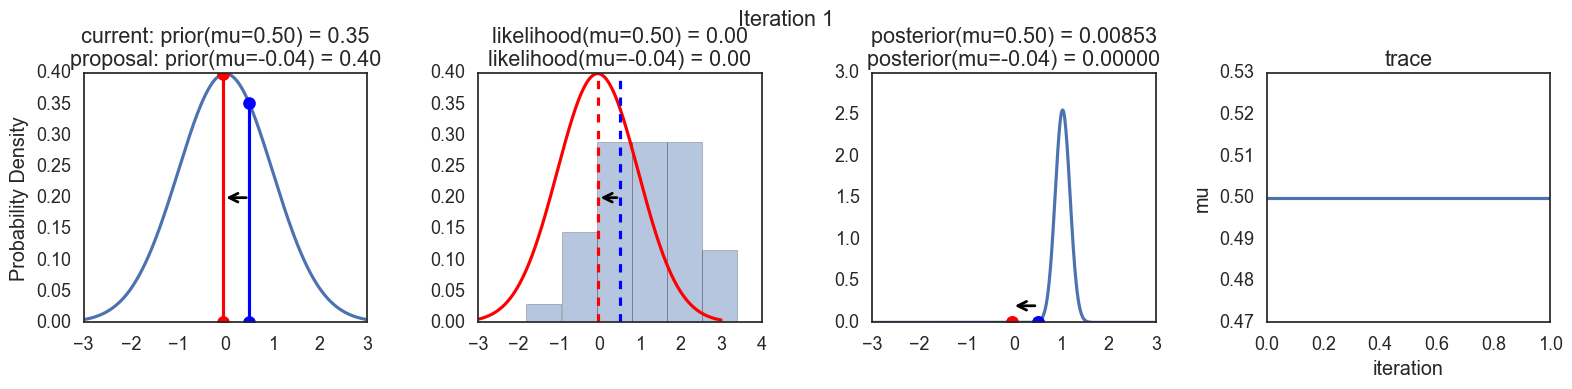

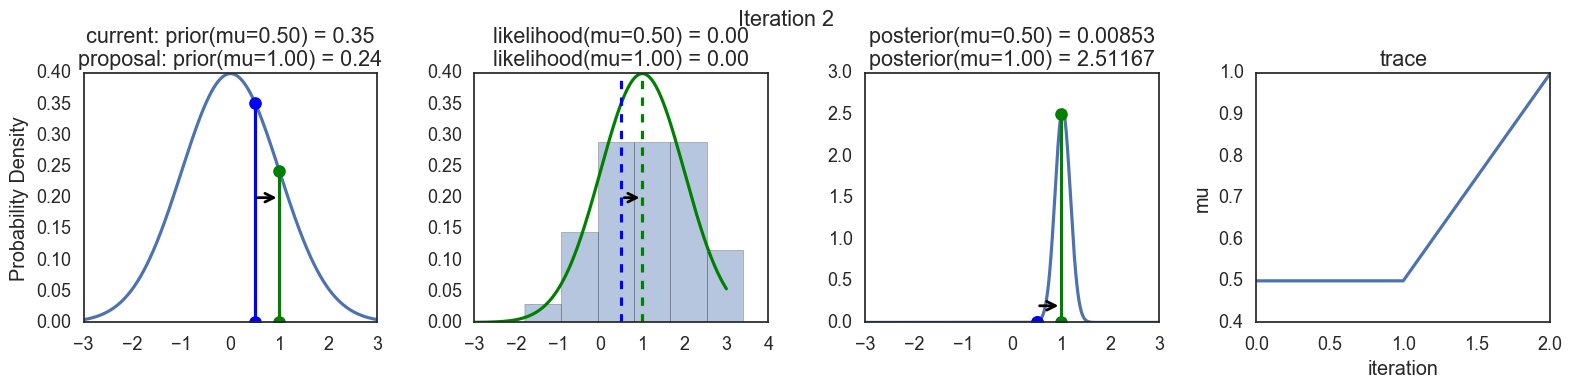

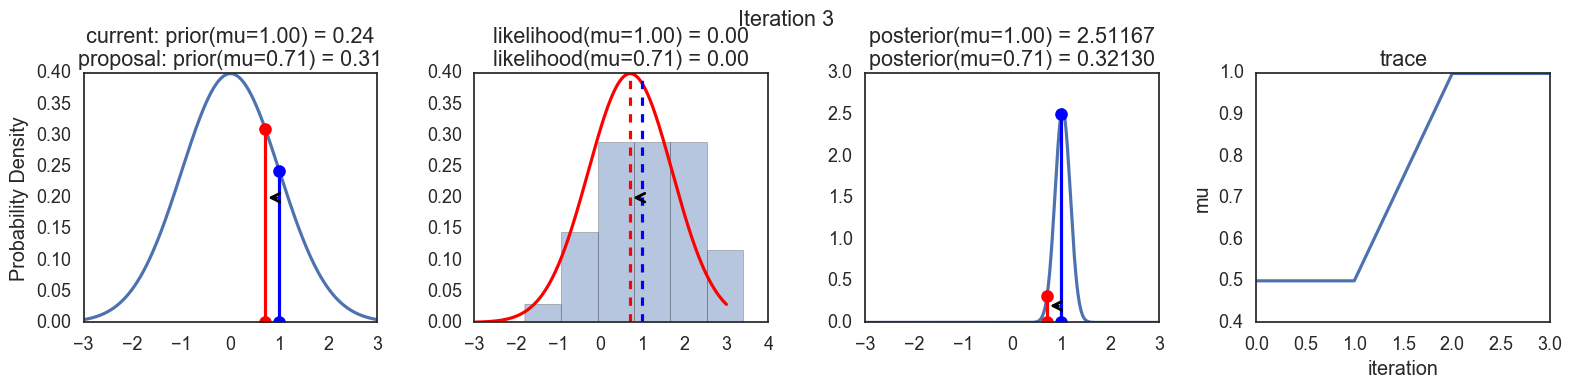

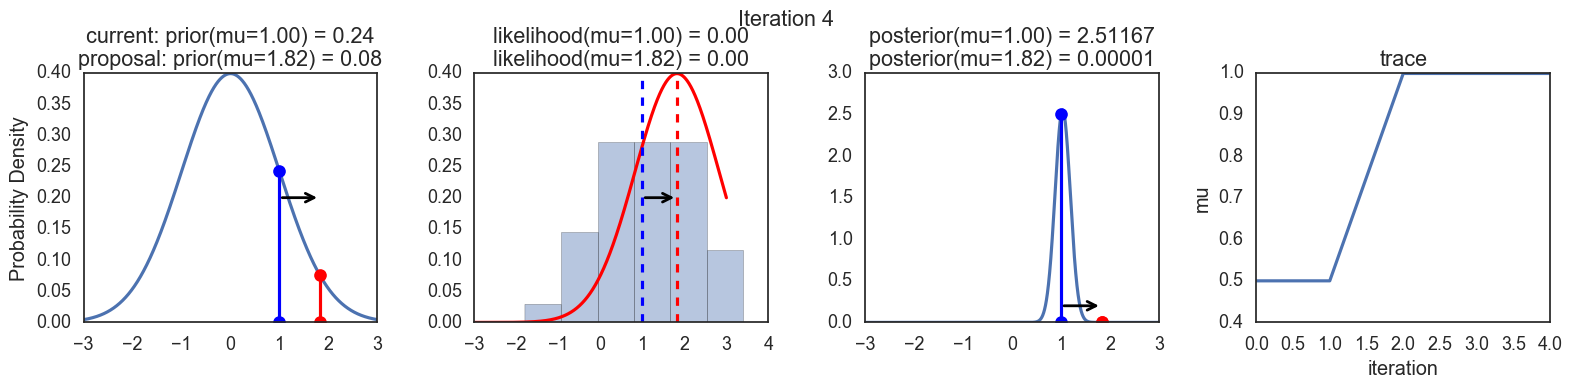

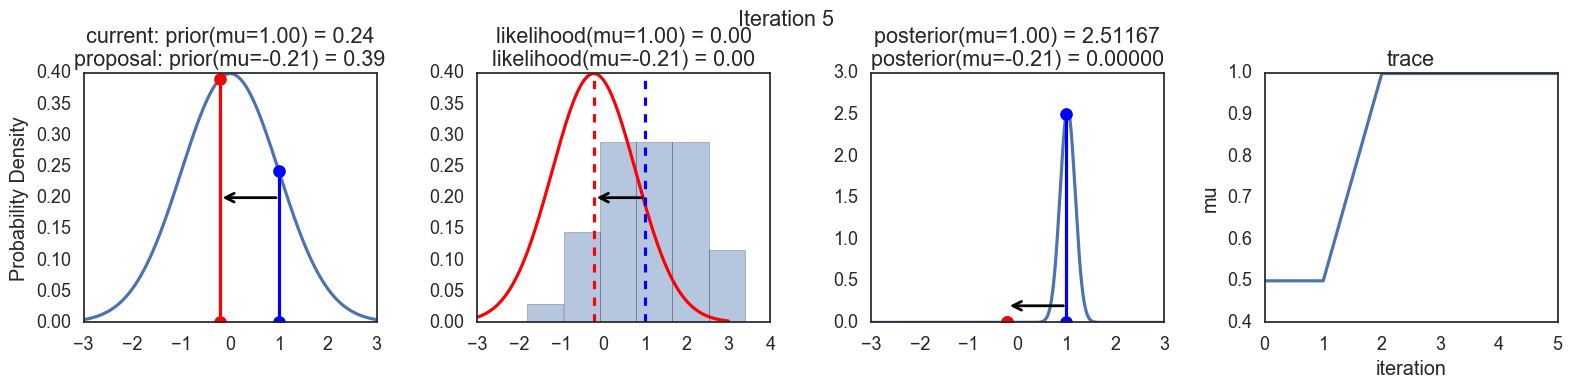

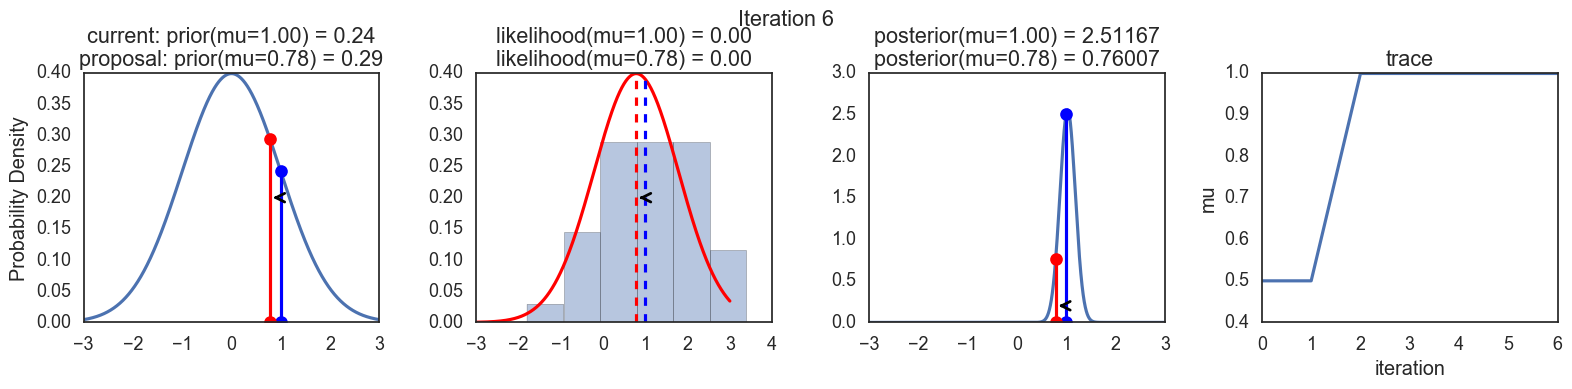

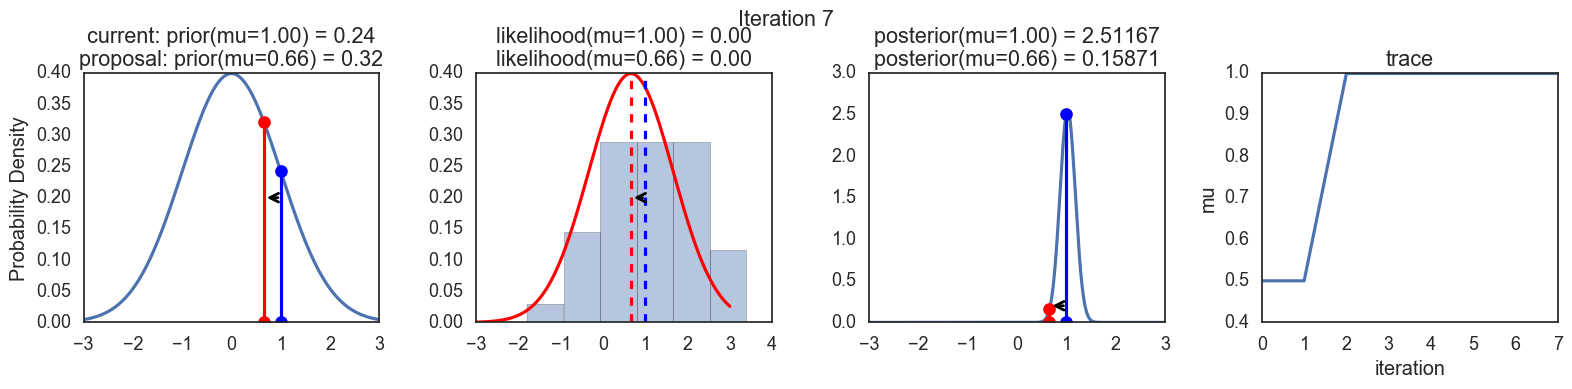

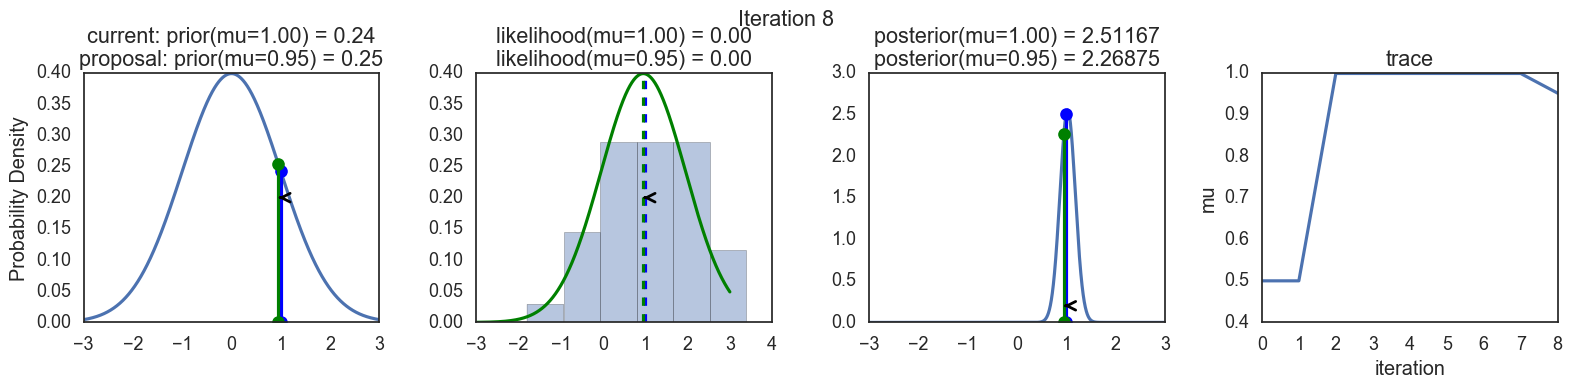

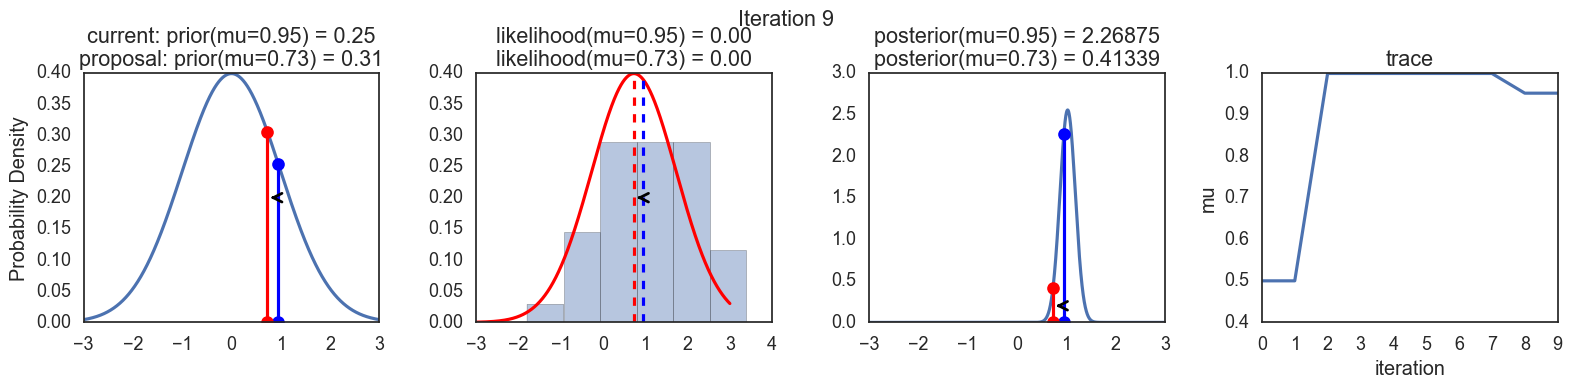

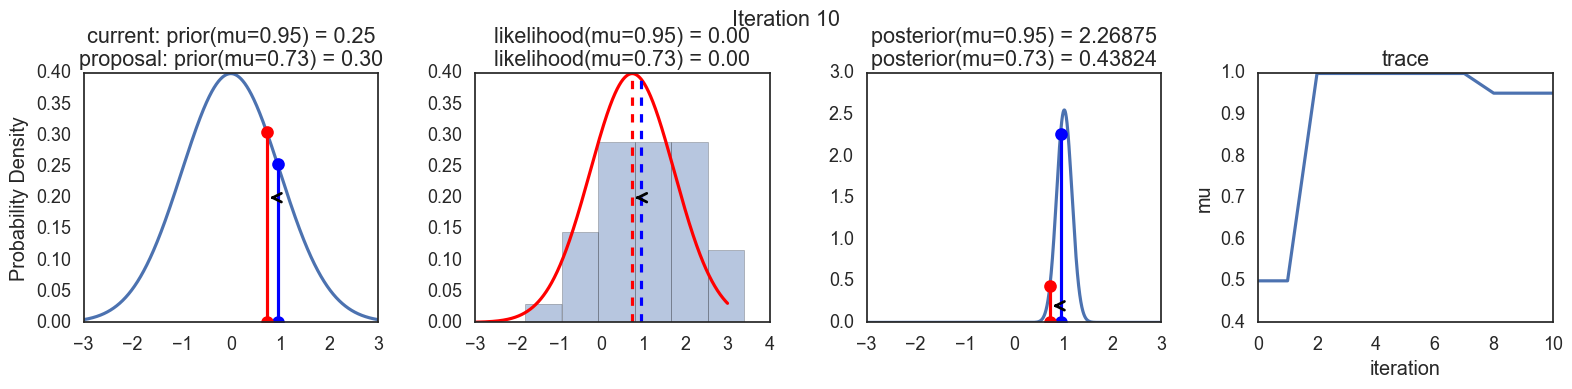

In [77]:
x = np.random.randn(40) + 1
np.random.seed(123)
sampler(x, samples=10, theta_init=0.5, plot=True);

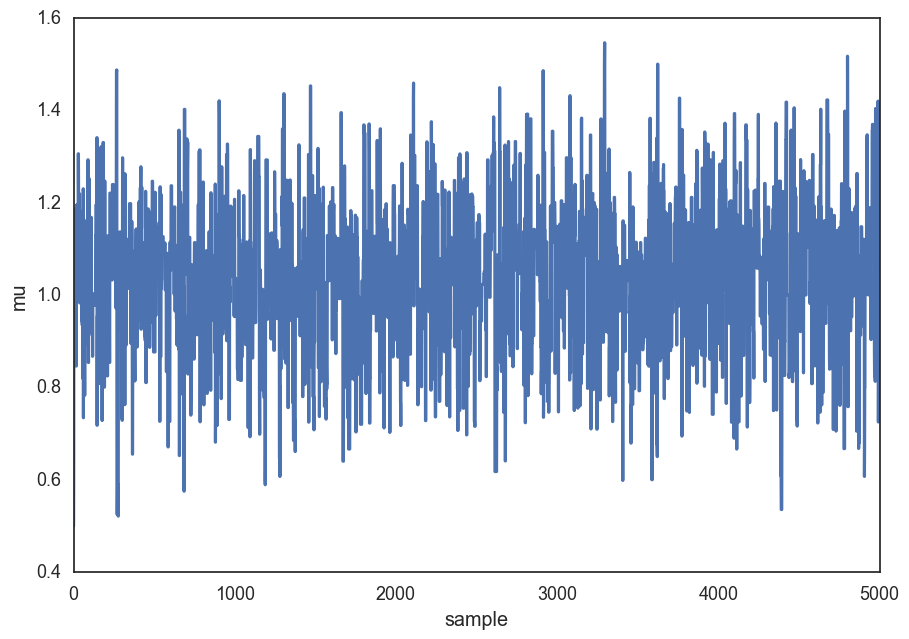

In [92]:
posterior = sampler(x, samples=5000, theta_init=0.5)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

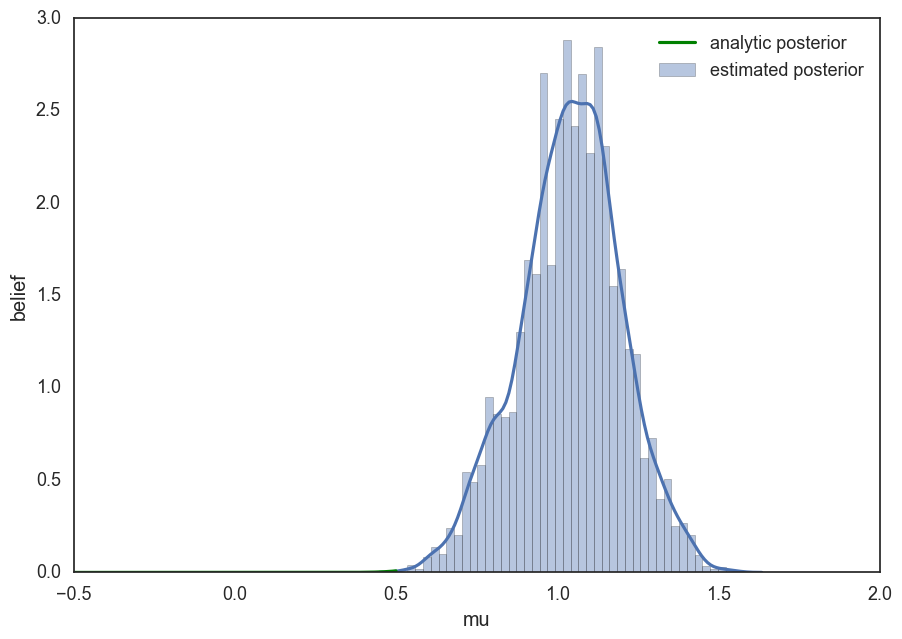

In [94]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x_s = np.linspace(-.5, .5, 500)

post = calc_posterior_analytical(x, x_s, 0, 1)

ax.plot(x_s, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();